## Fase 0 - Leitura do arquivo de entrada, sumarização e visualização dos dados

In [3]:
with open('InstanciaTeste.txt') as file:
    N = int(file.readline())
    R = int(file.readline())
    K = int(file.readline())
    H = int(file.readline())
    distribuitions = [file.readline().split() for i in range(R)]
    points = ["".join([file.readline(), "-1"]).split() for i in range(N-R)]
    vehicles = [file.readline().split(' ') for i in range(K)]
    

#### Exibição Inicial

Nesse bloco, serão mostrados os Centro de Distribuição (vermelhos) e o Cliente (azul).

Isto ajuda a elucidar a distribuição dos clientes para esse problema.

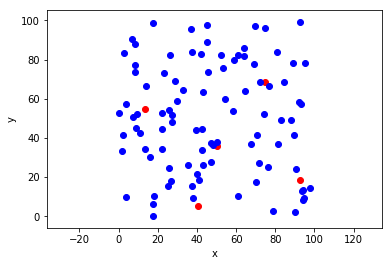

In [5]:
from matplotlib import pyplot as plt
import random
#para todos os centros:
plt.scatter([float(x) for x,_,_,_,_ in distribuitions], [float(y) for _,y,_,_,_ in distribuitions], color='red')
#para todos os clientes
plt.scatter([float(x) for x,_,_,_,_,_ in points], [float(y) for _,y,_,_,_,_ in points], color='blue')

#for p,d in zip(points, distribuitions):
#plt.annotate('dist', xy=(d[0],d[1]), xytext=(5,-5), textcoords='offset points')

#axis = Define os limites do plano. Nesse caso é definido como igual tanto para min,máx dos eixos X e Y.
plt.axis('equal')

#xlabel ou xlabel = Define o "nome" de cada eixo, nesse caso mantemos como X e Y
plt.xlabel("x")
plt.ylabel("y")

#show = exibe a plotagem dos pontos no plano cartesiano
plt.show()

# Fase 1

## Primeira Abordagem
Para cada `cliente (vértice)` calcule o `centro de distribuição` mais próximo.

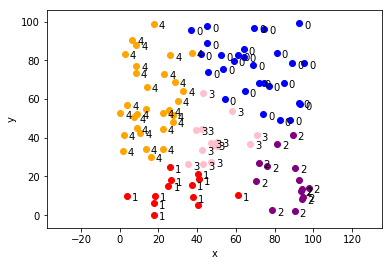

In [6]:
import sys
import math

colors = ['blue', 'red', 'purple', 'pink', 'orange']

def euclidian_distance(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)

for i,[point_x,point_y,_,_,_,_] in enumerate(points):
    menor = sys.maxsize
    for j,[distribuition_x,distribuition_y,_,_,_] in enumerate(distribuitions):
        if euclidian_distance(float(point_x), float(point_y), float(distribuition_x), float(distribuition_y)) < menor:
            menor = euclidian_distance(float(point_x), float(point_y), float(distribuition_x), float(distribuition_y))
            points[i][5] = j


for idx,[x,y,_,_,_] in enumerate(distribuitions):
    plt.scatter(float(x), float(y), color=colors[idx])

for x,y,_,_,_,dist in points:
    plt.scatter(float(x), float(y), color=colors[dist])
    
for p in points:
    plt.annotate(p[5], xy=(float(p[0]),float(p[1])), xytext=(5,-5), textcoords='offset points')
    
plt.axis('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## Segunda Abordagem

Utilizar o `diagrama de Voronoi` para `clusterizar` as regiões

Mais informações, leia: https://pt.wikipedia.org/wiki/Diagrama_de_Voronoy

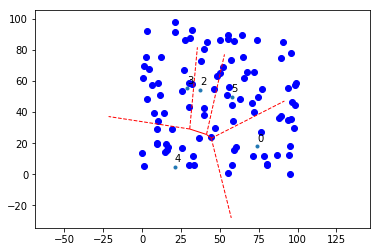

False
ridge_points
 [[3 0]
 [3 2]
 [1 4]
 [1 0]
 [1 2]
 [4 0]
 [0 2]]
ridge_vertices
 [[-1, 0], [-1, 0], [-1, 1], [1, 2], [-1, 2], [-1, 1], [0, 2]]
vertices
 [[44.47837464 23.14254197]
 [30.61169171 29.12172167]
 [41.41895196 25.60931334]]
regions
 [[-1, 0], [], [-1, 1, 2], [-1, 1], [2, 0, -1, 1], [-1, 0, 2]]
points
 [[21.03963459  4.68419041]
 [37.2356518  54.51739777]
 [57.546798   49.96234041]
 [73.85716829 17.94910753]
 [28.83004003 55.30650598]]
point_region
 [4 2 5 0 3]


In [6]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np

vor = Voronoi([(float(x),float(y)) for x,y,_,_,_ in distribuitions])
voronoi_plot_2d(vor, line_colors='red', show_vertices=False)

for idx,d in enumerate(distribuitions):
    plt.annotate(vor.point_region[idx], xy=(float(d[0]),float(d[1])), xytext=(0,5), textcoords='offset points')
    
for x,y,_,_,_,_ in points:
    plt.scatter(float(x), float(y), color='blue')
plt.axis('equal')

plt.show()

point = Point(0, 0)
polygon = Polygon([vor.vertices[i] for i in vor.regions[5] if not i == '-1'])
print(polygon.contains(point))

print("ridge_points\n", vor.ridge_points)
print("ridge_vertices\n", vor.ridge_vertices)
print("vertices\n", vor.vertices)
print("regions\n", vor.regions)
print("points\n", vor.points)
print("point_region\n", vor.point_region)

## Transformação para regiões finitas

[[3, 3, 0], (1, 1, 2), [4, 4, 1], (2, 0, 2)]
[[4, 5, 1], (0, 1, 2), [2, 6, 2]]
[[3, 7, 0], [1, 8, 2], (0, 0, 2)]
[[0, 9, 0], [2, 10, 0]]
[[1, 11, 1], [0, 12, 1]]


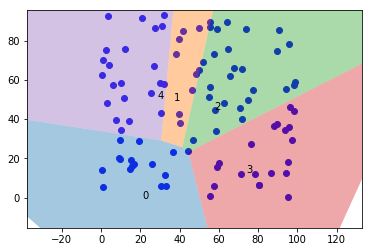

In [332]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_with_finite_polygons(vor):
    """
    
    """

    new_regions = []
    # Vértices do diagrama de voronoi
    new_vertices = vor.vertices.tolist()
    # Ponto médio entre os centros de distribuição
    center = vor.points.mean(axis=0)
    
    # Atualiza raio que dará a posição do vértice, d'antes infinito, no novo polígono
    radius = vor.points.ptp().max()*2

    # Estrutura para armazenar os vértices de voronoi que se cruza ao sair de um ponto de distribuição para um outro qualquer de região vizinha
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # Cálculo das regiões infinitas
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        
        # Se nenhum dos pontos da região possui um vértice no infinito
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]

        # Vértices que não estão no infinito
        new_region = [v for v in vertices if v >= 0]
        
        for idx, [p2, v1, v2] in enumerate(ridges):
            #print(p1, p2, v1, v2)
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # Ridge finita que já consta na região
                continue

            # Computa os pontos infinitos na região
            t = vor.points[p2] - vor.points[p1] # tangente
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            # Atualiza all_ridges com os novos vértices calculados
            v1 = len(new_vertices)
            ridges[idx] = [p2, v1, v2]
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        
        # Ordena as regiões de forma anti-horária
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices), all_ridges

dists = np.array([[float(x),float(y)] for x,y,_,_,_ in distribuitions])

# Cria diagrama de Voronoi
vor = Voronoi(dists)

# Transforma pontos infinitos em finitos
regions, vertices, all_ridges = voronoi_with_finite_polygons(vor)

# TODO: pegar valor max e min dos pontos de entrega e não dos pontos de distribuição
min_x = vor.min_bound[0] - 1000
max_x = vor.max_bound[0] + 1000
min_y = vor.min_bound[1] - 1000
max_y = vor.max_bound[1] + 1000

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

# Polígono geral do gráfico
box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

new_regions = []

for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]
    new_regions.append(poly)

    plt.fill(*zip(*polygon), alpha=0.4)

new_points = []
# Plota os pontos de entrega
for x,y,_,_,_,_ in points:
    plt.scatter(float(x), float(y), color='blue')
    for idx,region in enumerate(new_regions):
        if region.contains(Point(float(x), float(y))):
            # Imprime índice da região do ponto
            new_points.append([x,y,idx])
            #print(idx)


# Plota os indices das regiões
for idx,[x,y] in enumerate(dists):
    plt.annotate(idx, xy=(x,y), xytext=(0,-10), textcoords='offset points')

plt.axis('equal')
plt.xlim(vor.min_bound[0] - 20.1, vor.max_bound[0] + 20.1)
plt.ylim(vor.min_bound[1] - 20.1, vor.max_bound[1] + 40.1)

plt.show()

## Heurística para melhoramento das divisões das regiões

A ideia utilizada:

1. Ordenar as regiões, de forma decrescente, de acordo com a quantidade de pontos de entrega contidos nas mesmas.

2. As regiões com mais pontos irão _doar_ os pontos mais próximos de outra região com menos pontos

    2.1 Para isso, calculamos o ponto mais proximo da ridge entre duas regiões
    
    2.2 Calculamos em qual posição do polígono este ponto será inserido
    
    2.3 Atualiza as duas regiões (polígonos) com o novo vértice


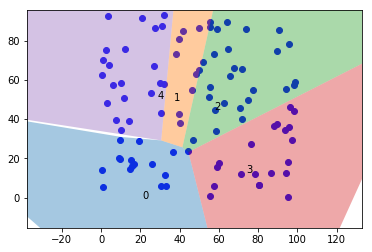

In [335]:
from collections import Counter

# Estrutura que armazena, em ordem decrescente, a quantidade de pontos por região
points_per_region = Counter(np.array(new_points)[:,2]).most_common()

def region_is_neighborhood(p1,p2):
    """ Verifica se duas regiões são vizinhas"""
    for points in all_ridges[p1]:
        if p2 in points:
            return True
    return False

def get_near_to_ridge_between_two_regions(p1,p2):
    """ Pegar o ponto mais próximo entre a linha que divide duas regiões desequilibradas"""
    pass

# TODO: Índice não está correto
def get_index_in_new_polygon(p1, p2):
    """ Retornar o index do novo ponto a ser incluído em um polígono existente """
    # Separa os dois vértices que formam a ridge entre os dois polígonos
    ridge_vertices = [[v1,v2] for p, v1, v2 in all_ridges[p1] if p == p2][0]

    for idx, v in enumerate(regions[p1]):
        if idx == 0:
            pass
        else:
            if (v, regions[p1][idx-1]) == (ridge_vertices[0], ridge_vertices[1]) or (regions[p1][idx-1], v) == (ridge_vertices[0], ridge_vertices[1]):
                position_p1 = idx - 1
    
    return position_p1


def update_polygon(p1, p2, point):
    """
    Atualiza polígono(região) com o novo ponto
    
    :param p1: Índice do polígono 1
    :param p2: Índice do polígono 2
    :param point: Ponto a ser inserido como vértice do polígono. Tupla(x,y).
    """
    
    if not region_is_neighborhood(p1,p2):
        return False
    
    # TODO: FAZER O MESMO PROCEDIMENTO PARA OS DOIS POLIGONOS, POIS UM IRÁ AUMENTAR ATÉ O PONTO QUISTO E O OUTRO DIMINUIR ATÉ O PONTO QUISTO
    # Guarda as coordenadas do poligono a ser alterado
    coords_p1 = new_regions[p1].exterior.coords[:]
    #coords_p2 = new_regions[p2].exterior.coords[:]
    
    # Posição da região onde será incluído o vértice
    position_p1 = get_index_in_new_polygon(p1,p2)
    
    # Inclui o ponto na posição correta
    coords_p1 = coords_p1[:position_p1] + [point] + coords_p1[position_p1:]
    #coords_p2 = coords[:position_p2] + [point] + coords[position_p2:]

    # Cria novo poligono e o adiciona como uma região
    new_p1 = Polygon(coords_p1)
    #new_p2 = Polygon(coords_p2)
    
    new_regions[p1] = new_p1
    #new_regions[p2] = new_p2
    
def colorize_polygons():
    for poly in new_regions:
        polygon = [p for p in poly.exterior.coords]
        plt.fill(*zip(*polygon), alpha=0.4)

update_polygon(0, 4,(10.213724010652633, 30.890770737064063))
colorize_polygons()
new_points = []

# Plota os pontos de entrega
for x,y,_,_,_,_ in points:
    plt.scatter(float(x), float(y), color='blue')
    for idx,region in enumerate(new_regions):
        if region.contains(Point(float(x), float(y))):
            # Para cada ponto de entrega, associa o indice da região
            new_points.append([x,y,idx])



# Plota os indices das regiões
for idx,[x,y] in enumerate(dists):
    plt.annotate(idx, xy=(x,y), xytext=(0,-10), textcoords='offset points')

plt.axis('equal')
plt.xlim(vor.min_bound[0] - 20.1, vor.max_bound[0] + 20.1)
plt.ylim(vor.min_bound[1] - 20.1, vor.max_bound[1] + 40.1)

plt.show()

# Fase 2

...